# using gollum for grid interface

Let's use gollum

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

In [2]:
from gollum.phoenix import PHOENIXSpectrum

In [3]:
import astropy.units as u

In [4]:
spec = PHOENIXSpectrum(teff=9_600, logg=4.5).instrumental_broaden(resolving_power=55_000).normalize()

In [5]:
mask = (spec.wavelength < 11_400*u.Angstrom) & (spec.wavelength> 11_100*u.Angstrom)
spec = spec._copy(spectral_axis = spec.wavelength.value[mask]*u.Angstrom,
                 flux=spec.flux[mask],
                 wcs=None)

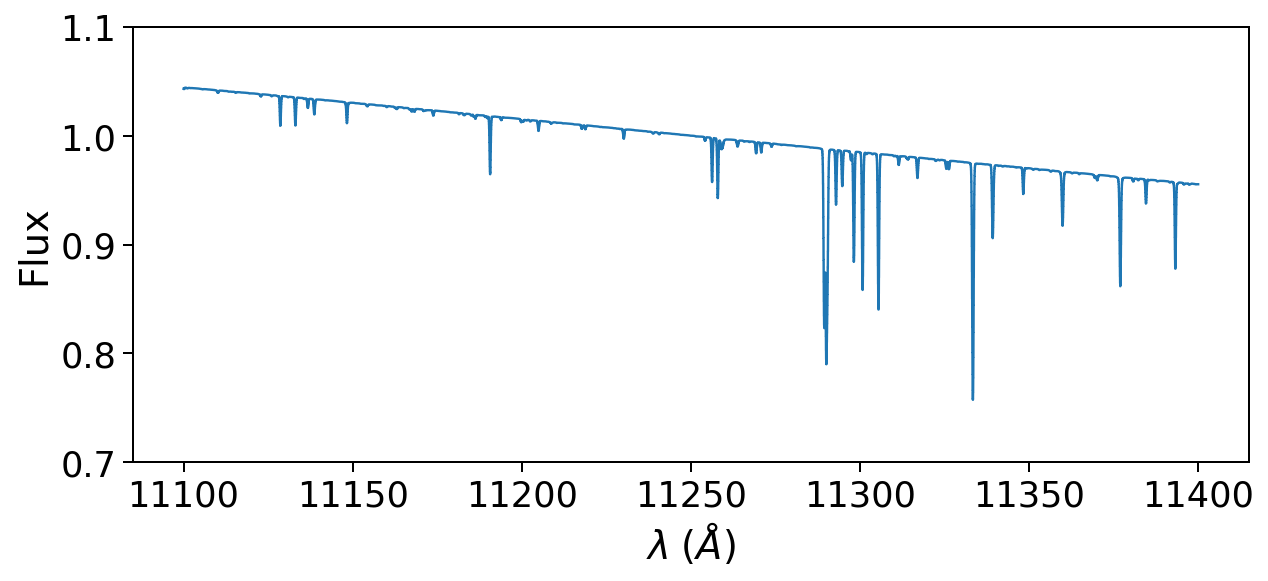

In [6]:
spec.normalize().plot(ylo=0.7, yhi=1.1);

In [7]:
x_vector = spec.wavelength.value

In [8]:
y_vector = spec.flux.value

Let's find the lines.

In [ ]:
from scipy.signal import find_peaks, peak_prominences, peak_widths

In [ ]:
flux_native = y_vector
wl_native = x_vector

In [ ]:
peaks, _ = find_peaks(-flux_native, distance=10, prominence=0.005)
prominence_data = peak_prominences(-flux_native, peaks)
width_data = peak_widths(-flux_native, peaks, prominence_data=prominence_data)
lam_centers = wl_native[peaks]
prominences = torch.tensor(prominence_data[0])
widths = width_data[0]
d_lam = np.diff(wl_native)[peaks]
# Convert FWHM in pixels to Gaussian sigma in Angstroms
widths_angs = torch.tensor(widths * d_lam / 2.355)

In [ ]:
n_lines = len(lam_centers)

In [ ]:
#lam_centers, prominences, widths_angs

make a linear model from these data

In [ ]:
x_vector.shape

In [ ]:
A_012 = np.vander(x_vector, N=3)

In [ ]:
A_gauss = 1.0/(widths_angs[:, np.newaxis]*np.sqrt(2.0*np.pi))*(np.exp(-0.5*(x_vector-lam_centers[:, np.newaxis])**2/
       (widths_angs[:, np.newaxis])**2))

In [ ]:
lnA_gauss = np.log(1.0/(widths_angs[:, np.newaxis]*np.sqrt(2.0*np.pi))) +(-0.5*(x_vector-lam_centers[:, np.newaxis])**2/
       (widths_angs[:, np.newaxis])**2)

In [ ]:
A_lorentz = 1/3.141592654* widths_angs[:, np.newaxis]/ (widths_angs[:, np.newaxis] ** 2 + (x_vector - lam_centers[:, np.newaxis]) ** 2)

In [ ]:
lnA_lorentz = np.log(1/3.141592654 * widths_angs[:, np.newaxis]/ (widths_angs[:, np.newaxis] ** 2 + (x_vector - lam_centers[:, np.newaxis]) ** 2))

In [ ]:
def pseudo_voigt(eta):
    '''A pseudo Voigt Profile'''
    return eta * A_lorentz + (1.0-eta) * A_gauss
    

In [ ]:
A = np.log(np.hstack([A_012, pseudo_voigt(0.0).T]))

In [ ]:
np.sqrt(2*3.141592654)

In [ ]:
A.shape

In [ ]:
ATA = np.dot(A.T, A)

In [ ]:
2*np.sqrt(2*np.log(2)) * torch.tensor([7.1])

In [ ]:
sigma_w = np.linalg.inv(ATA)

In [ ]:
mean_w = np.linalg.solve(ATA, np.dot(A.T, np.log(y_vector)))

In [ ]:
#y_slope = np.dot(A_012, mean_w[0:3])

In [ ]:
#y_lines = np.dot(A_gauss.T, prominences)

In [ ]:
y_hat = np.dot(A, mean_w)

In [ ]:
mean_w

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(x_vector, np.log(y_vector))
plt.plot(x_vector, y_hat)
#plt.xlim(11280, 11300)

In [ ]:
class PhoenixEmulator(nn.Module):
    r"""
    A PyTorch layer that clones precomputed synthetic spectra

    Teff (int): The Teff label of the PHOENIX model to read in.  Must be on the PHOENIX grid.
    logg (float): The logg label of the PHOENIX model to read in.  Must be on the PHOENIX grid.

    Currently hardcoded to assume your PHOENIX grid is stored at: ~/libraries/raw/PHOENIX/
    """

    def __init__(self, Teff, logg, prominence=0.03):
        super().__init__()

        self.Teff, self.logg = Teff, logg

        # Read in the synthetic spectra at native resolution
        self.wl_native, self.flux_native = self.read_native_PHOENIX_model(Teff, logg)

        (lam_centers, amplitudes, widths_angstroms,) = self.detect_lines(
            self.wl_native, self.flux_native, prominence=prominence
        )


    def forward(self, wl):
        """The forward pass of the spectral model

        Returns:
            (torch.tensor): the 1D generative spectral model destined for backpropagation parameter tuning
        """
        return self.sum_of_lorentzian_model(wl)
        # return self.sum_of_voigts_model(wl)

# Emulator

In [9]:
import torch

In [10]:
from blase.emulator import PhoenixEmulator

Woohoo! You have a version 1.11.0.dev20211008 of PyTorch


In [ ]:
PhoenixEmulator

In [3]:
! ls -t1 ../examples/*.pt

../examples/native_res_0p1prom.pt
../examples/model_coeffs.pt


In [4]:
! du -hs '../examples/native_res_0p1prom.pt'

164K	../examples/native_res_0p1prom.pt


In [5]:
with torch.no_grad():
    model_params = torch.load('../examples/native_res_0p1prom.pt')

In [6]:
bad_mask = (model_params['amplitudes']>0)

In [7]:
bad_mask.sum()

tensor(3, device='cuda:0')

In [8]:
model_params['amplitudes'][bad_mask] = 0

In [11]:
emulator = PhoenixEmulator(4700, 4.5, prominence=0.03,)

In [13]:
emulator.read_native_PHOENIX_model(4700, 4.5)

(tensor([ 8038.0100,  8038.0200,  8038.0300,  ..., 12848.9400, 12848.9600,
         12848.9800], dtype=torch.float64),
 tensor([1.3452, 1.3453, 1.3456,  ..., 0.6621, 0.6617, 0.6609],
        dtype=torch.float64))

In [10]:
emulator.load_state_dict(model_params)

<All keys matched successfully>

This step takes a *TON* of RAM unless you use `torch.no_grad`!

In [ ]:
with torch.no_grad():
    cloned_spectrum = emulator.forward(emulator.wl_native)

In [ ]:
type(cloned_spectrum), cloned_spectrum.shape

## $\pm 2.5\%$ residuals with a long tail

At native resolution

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_context('paper', font_scale=2)

In [ ]:
plt.figure(figsize=(20, 5))
plt.step(emulator.wl_native, emulator.flux_native, label='PHOENIX model', alpha=0.5)
plt.step(emulator.wl_native, cloned_spectrum.detach(), label='Clone', alpha=0.5)
plt.legend()
plt.ylim(0, 1.4)
plt.xlim(8_450, 8_600)
#plt.xlim(10_000, 10_010)
#plt.xlim(10_900, 11_010)

In [ ]:
residual = emulator.flux_native - cloned_spectrum.detach()

In [ ]:
stddev = torch.std(residual)

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(emulator.wl_native, residual*100.0, label='Residual')
plt.axhline(+stddev*100, color='k', linestyle='dashed')
plt.axhline(-stddev*100, color='k', linestyle='dashed')
plt.ylim(-10, 10)
plt.ylabel('Residual (%)')

Hmmm, those residuals seem large compared to the reported residuals after training... did something go wrong when we loaded them in?  Is there some hysteresis when loading a model?  A rounding error?

How big are the residuals when you smooth them to HPF resolution?

## Smooth to HPF resolution

In [ ]:
from gollum.phoenix import PHOENIXSpectrum
import astropy.units as u

from muler.hpf import HPFSpectrumList

In [ ]:
original_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=emulator.flux_native*u.dimensionless_unscaled)

In [ ]:
clone_native = PHOENIXSpectrum(spectral_axis=emulator.wl_native*u.Angstrom, 
                                flux=cloned_spectrum*u.dimensionless_unscaled)

In [ ]:
echelle_orders = HPFSpectrumList.read('../../muler_example_data/HPF/01_A0V_standards/Goldilocks_20210517T054403_v1.0_0060.spectra.fits')

In [ ]:
hpf_spectrum = echelle_orders.sky_subtract(method='vector')\
                                .deblaze()\
                                .normalize()\
                                .remove_nans()\
                                .trim_edges((6,2042))\
                                .stitch()

In [ ]:
def simulate_observation(spectrum):
    """Simulate an observation with HPF"""
    return spectrum.rotationally_broaden(13.5)\
                    .rv_shift(0.0)\
                    .instrumental_broaden(resolving_power=55_000)\
                    .resample(hpf_spectrum)

In [ ]:
original_sim = simulate_observation(original_native)
clone_sim = simulate_observation(clone_native)

In [ ]:
ax = original_sim.plot(ylo=0, yhi=2)
clone_sim.plot(ax=ax)

In [ ]:
ax = original_sim.plot(ylo=0.5, yhi=1, color='g', lw=2)
clone_sim.plot(ax=ax, color='k', lw=1)
plt.step(emulator.wl_native, emulator.flux_native, label='PHOENIX model', alpha=0.5, color='r', where='mid')
plt.step(emulator.wl_native, cloned_spectrum.detach(), label='Clone', alpha=0.5, color='b', where='mid')
ax.plot()
ax.set_xlim(10820, 10960)

Yuck!  The cloning is not adequate at this zoom level.  Did we not train long enough?

In [ ]:
residual_spec = (original_sim - clone_sim)*100

In [ ]:
stddev = residual_spec.flux.std().value

In [ ]:
stddev

## $\pm 0.9\%$ residuals after smoothing and resampling


In [ ]:
ax = residual_spec.plot(ylo=-10, yhi=10)
ax.axhline(+stddev, color='k', linestyle='dashed')
ax.axhline(-stddev, color='k', linestyle='dashed')
ax.set_ylabel('Residual (%)')

We still want better than 1%!  That level of residual is comparable to the SNR of a real spectrum.

## Clustering of parameters

In [ ]:
amps, widths = model_params['amplitudes'].detach().cpu().numpy(), model_params['gamma_widths'].detach().cpu().numpy()

In [ ]:
amps, widths = np.exp(amps), np.exp(widths)

In [ ]:
plt.plot(widths,amps, 'o', alpha=0.1)
plt.yscale('log'), plt.xscale('log')
plt.xlabel('$\gamma_L \; (\AA) $'); plt.ylabel('Amplitude');

Hmm, I'd expect to see continuum overfitting in the bottom right corner:  Wide lines with low amplitude.

In [ ]:
from scipy.signal import find_peaks

In [ ]:
biggest_residuals = find_peaks(np.abs(residual), height=0.1)

In [ ]:
indices, meta_info = biggest_residuals

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(emulator.wl_native, np.abs(residual*100.0), label='Residual')
plt.ylim(0, 100)

plt.plot(emulator.wl_native[indices], 100*meta_info['peak_heights'], 'ro')
plt.ylabel('Residual (%)')